## Search-Based Ranger and Drone Patrol Routing
This notebook includes:
- Weight model
- Search interpretation
- Edge weight labels
- Nodes expanded for UCS & A*
- Final interpretation summary


## 1. Constructing the 5×5 Patrol Grid
We build a simple 5×5 grid (25 nodes). Each node represents a reserve zone. Edges represent paths.
Each node connects to its immediate **up/down/left/right** neighbors.


In [1]:

import math, copy, matplotlib.pyplot as plt

positions={}
base_graph={}
idx=0
for r in range(5):
    for c in range(5):
        positions[f"N{idx}"]=(r,c)
        base_graph[f"N{idx}"]={}
        idx+=1

def node(r,c): return f"N{r*5+c}"

for r in range(5):
    for c in range(5):
        u=node(r,c)
        if r>0: base_graph[u][node(r-1,c)] = 1
        if r<4: base_graph[u][node(r+1,c)] = 1
        if c>0: base_graph[u][node(r,c-1)] = 1
        if c<4: base_graph[u][node(r,c+1)] = 1

terrain_penalty={'flat':0,'rocky':2,'forest':3,'river':4}
terrain_type={n:'flat' for n in positions}
poaching_density={n:0.2 for n in positions}

migration_zone=['N6','N7','N8']
high_risk_defaults=['N12','N18']
heat_cost={'low':1.0,'medium':1.3,'high':1.6}

print("5x5 grid created.")


5x5 grid created.


## 2. Collecting Scenario Inputs
Few of the constraints are hardcoded and defaulted in to the edge's base weights, the other constraints are taken as user inputs that influence weights:
- **Time** → affects visibility
- **Weather** → affects sensing & movement
- **Season** → affects terrain difficulty
- **Mode** → ranger or drone (drone gets advantage)
- **Alert Node** → destination of patrol
- **Thermal Level** → determines danger spread


In [2]:

print("-------Press Enter to use default []----------")

time_of_day = input("Time (day/night) [night]: ").strip().lower() or "night"
weather = input("Weather (clear/foggy/rainy) [foggy]: ").strip().lower() or "foggy"
season = input("Season (dry/monsoon/winter) [dry]: ").strip().lower() or "dry"
mode = input("Mode (ranger/drone) [ranger]: ").strip().lower() or "ranger"
alert_node = input("Alert node (N0..N24) [N12]: ").strip().upper() or "N12"
alert_heat = input("Thermal (low/medium/high) [high]: ").strip().lower() or "high"

print("\nINPUT SUMMARY:")
print("Time:", time_of_day)
print("Weather:", weather)
print("Season:", season)
print("Mode:", mode)
print("Alert Node:", alert_node)
print("Thermal:", alert_heat)


-------Press Enter to use default []----------
Time (day/night) [night]: 
Weather (clear/foggy/rainy) [foggy]: 
Season (dry/monsoon/winter) [dry]: 
Mode (ranger/drone) [ranger]: 
Alert node (N0..N24) [N12]: n8
Thermal (low/medium/high) [high]: 

INPUT SUMMARY:
Time: night
Weather: foggy
Season: dry
Mode: ranger
Alert Node: N8
Thermal: high


## 3. Building the Weighted Graph
We begin with base edge weight = 1, then modify based on environmental factors that we hardcoded and the few factors that we get from the user.


In [3]:

import heapq

def compute_graph():
    g=copy.deepcopy(base_graph)
    visibility={'day':0.9,'night':1.3}[time_of_day]
    weather_mult={'clear':1.0,'foggy':1.2,'rainy':1.4}[weather]
    season_mult={'dry':1.2,'monsoon':1.5,'winter':1.0}[season]
    drone_mode=(mode=='drone')

    heat_levels={n:'low' for n in positions}
    if alert_heat=='high':
        heat_levels[alert_node]='high'
        for nei in base_graph[alert_node]: heat_levels[nei]='medium'
    elif alert_heat=='medium':
        heat_levels[alert_node]='medium'
        for nei in base_graph[alert_node]: heat_levels[nei]='low'

    for u in g:
        for v in g[u]:
            c=base_graph[u][v]
            c+=terrain_penalty[terrain_type[u]] + terrain_penalty[terrain_type[v]]
            c*=visibility
            c*=weather_mult
            c*=heat_cost[heat_levels[u]] * heat_cost[heat_levels[v]]
            c*=season_mult
            c*=(1+poaching_density[u])*(1+poaching_density[v])
            if u in migration_zone or v in migration_zone: c*=1.4
            if u in high_risk_defaults or v in high_risk_defaults: c*=1.5
            if drone_mode and c>3: c*=0.7
            g[u][v]=round(c,3)

    return g

graph = compute_graph()


## 4. Running UCS and A*



In [4]:

def ucs(graph,start,goal):
    pq=[(0,start,[])]
    vis=set()
    expanded=0
    while pq:
        c,u,path=heapq.heappop(pq)
        if u in vis: continue
        vis.add(u)
        expanded+=1
        path=path+[u]
        if u==goal: return path,c,expanded
        for nei,w in graph[u].items():
            heapq.heappush(pq,(c+w,nei,path))
    return None,None,expanded

def heuristic(a,b):
    (r1,c1)=positions[a]; (r2,c2)=positions[b]
    return abs(r1-r2)+abs(c1-c2)

def astar(graph,start,goal):
    pq=[(heuristic(start,goal),0,start,[])]
    vis=set()
    expanded=0
    while pq:
        f,g,u,path=heapq.heappop(pq)
        if u in vis: continue
        vis.add(u)
        expanded+=1
        path=path+[u]
        if u==goal: return path,g,expanded
        for nei,w in graph[u].items():
            ng=g+w
            heapq.heappush(pq,(ng+heuristic(nei,goal),ng,nei,path))
    return None,None,expanded

ucs_path,ucs_cost,ucs_expanded = ucs(graph,'N0',alert_node)
astar_path,astar_cost,astar_expanded = astar(graph,'N0',alert_node)

print("UCS:",ucs_path,ucs_cost,"Expanded:",ucs_expanded)
print("A* :",astar_path,astar_cost,"Expanded:",astar_expanded)


UCS: ['N0', 'N1', 'N2', 'N3', 'N8'] 16.746000000000002 Expanded: 19
A* : ['N0', 'N1', 'N2', 'N3', 'N8'] 16.746000000000002 Expanded: 15


## 5. Visualizing the Route
This plot shows:
- Grid layout
- Node labels
- Edge weights in blue
- Highlighted path
- Alert node circled in red


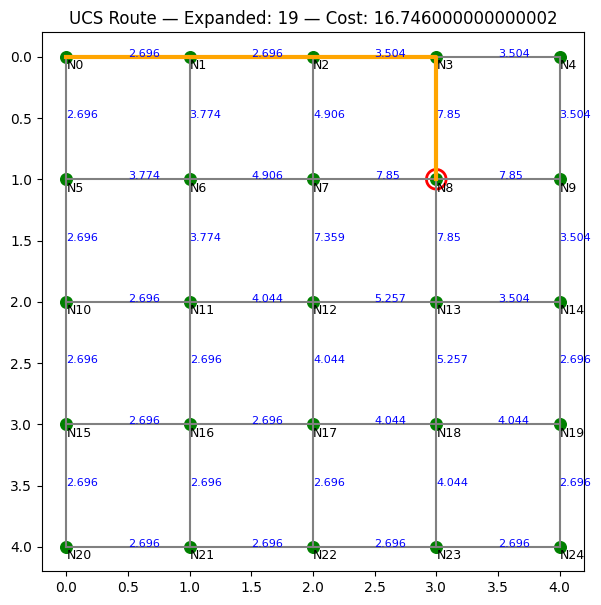

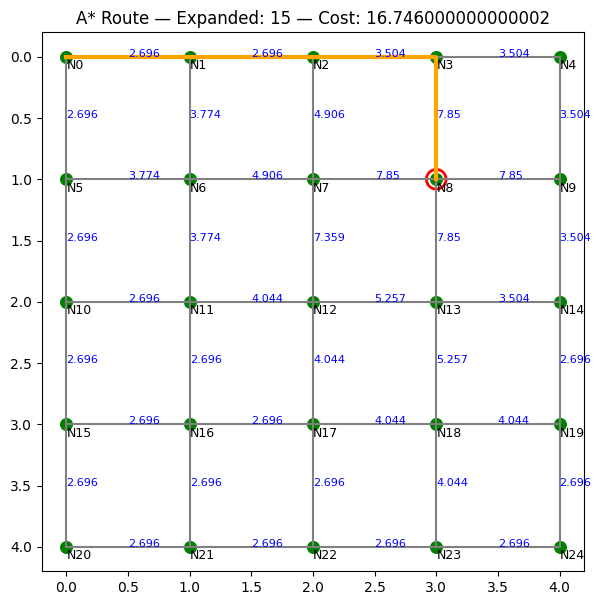

In [5]:

def draw(graph,path,title):
    fig,ax=plt.subplots(figsize=(7,7))
    drawn=set()

    for u in graph:
        r1,c1=positions[u]
        for v,w in graph[u].items():
            if (v,u) in drawn: continue
            r2,c2=positions[v]
            ax.plot([c1,c2],[r1,r2],'gray')
            mx,my=(c1+c2)/2,(r1+r2)/2
            ax.text(mx,my,str(w),fontsize=8,color='blue')
            drawn.add((u,v))

    for n,(r,c) in positions.items():
        ax.scatter(c,r,s=70,color='green')
        ax.text(c,r+0.1,n,fontsize=9)

    ar,ac=positions[alert_node]
    ax.scatter(ac,ar,s=200,facecolors='none',edgecolors='red',linewidth=2)

    if path:
        px=[positions[x][1] for x in path]
        py=[positions[x][0] for x in path]
        ax.plot(px,py,'orange',linewidth=3)

    ax.set_title(title)
    ax.invert_yaxis()
    plt.show()

draw(graph,ucs_path,f"UCS Route — Expanded: {ucs_expanded} — Cost: {ucs_cost}")
draw(graph,astar_path,f"A* Route — Expanded: {astar_expanded} — Cost: {astar_cost}")


## 6. Interpretation & Summary
### Why UCS and A* have the same cost:
- Graph is grid
- Heuristic is admissible
- Both algorithms find optimal path

### Key takeaways:
- **UCS** explored more nodes → slower
- **A*** explored fewer nodes → faster but same result
- Environmental factors strongly influenced weights
- Thermal propagation created dynamic risk zones
